In [6]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

import statsmodels.api as sm
import ast
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
from sklearn.utils import resample
import seaborn as sns
from matplotlib import pyplot as plt
from joblib import Parallel, delayed

rd = pd.read_excel('./Resources/combined_phecodex_list.xlsx')
cd = rd.loc[rd['Type'] == 'Common']

def cb(series):
    return series.apply(lambda x: 1 if x > 0 else 0)

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# Optional plotting function
if True:
    import os
    import matplotlib
    import matplotlib.font_manager as font_manager

    font_path = '/sc/arion/projects/GENECAD/Robert/arial.ttf'
    assert os.path.exists(font_path)
    font_manager.fontManager.addfont(font_path)
    prop = font_manager.FontProperties(fname=font_path)

    matplotlib.rc('font', family='sans-serif')
    matplotlib.rcParams.update({
        'font.size': 12,
        'font.sans-serif': prop.get_name(),
        'axes.titlesize': 12
    })

def bootstrap_ci_parallel_joblib(y_true, y_pred, n_bootstraps=1000, alpha=0.05, seed=42, n_jobs=-1):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    n = y_true.shape[0]

    def _one(i):
        rng = np.random.default_rng(seed + i)
        idx = rng.integers(0, n, size=n, endpoint=False)
        yt = y_true[idx]; yp = y_pred[idx]
        if yt.min() == yt.max():
            return None
        return float(roc_auc_score(yt, yp)), float(average_precision_score(yt, yp))

    res = Parallel(n_jobs=n_jobs, backend="loky", prefer="processes")(
        delayed(_one)(i) for i in range(n_bootstraps)
    )
    aurocs = [a for a in (r[0] if r else None for r in res) if a is not None]
    auprcs = [p for p in (r[1] if r else None for r in res) if p is not None]

    def _ci(arr):
        arr = np.asarray(arr)
        return (float(np.percentile(arr, 2.5)),
                float(np.mean(arr)),
                float(np.percentile(arr, 97.5)))

    return {'auroc': _ci(aurocs), 'auprc': _ci(auprcs)}
    

In [3]:
alldata = pd.read_pickle('./Final/ml_input.pkl')

alldata['xscore'] = 0.0
alldata.loc[alldata['phase'] == 0.5, 'xscore'] = 1*0.732*0.548*0.580*0.911
alldata.loc[alldata['phase'] == 1, 'xscore'] = 1*0.732*0.548*0.580
alldata.loc[alldata['phase'] == 2, 'xscore'] = 1*0.732*0.548
alldata.loc[alldata['phase'] == 3, 'xscore'] = 1*0.732
alldata.loc[alldata['phase'] == 4, 'xscore'] = 1

indata = alldata.loc[alldata['drug_gene'] == 1]

ind = indata.groupby('phecode')['indication'].max().reset_index()
ind = ind.loc[ind['indication'] == 1]
indata = indata.loc[indata['phecode'].isin(ind['phecode'])]
print(indata['phecode'].nunique())

#####

clin = ['clingen','eva','gene2phenotype','genomics_england','orphanet','uniprot_literature', 'uniprot_variants']
ot = ['clin_ot','hgmd','gwas_credible_sets','expression_atlas','impc','europepmc']
mantis = ['mantis']
cc = ['cc_common_max_p','cc_rare_max_p','cc_rare_burden_max_p','cc_ultrarare_max_p']


112


## By year

In [34]:
ed = pd.read_pickle('./Resources/earliest_date.pkl')    

results = []

conds = ['ot','mantis','cc','ot_mantis','ot_mantis_cc']

for subset in ['< 2005','2005-2015','> 2015']:
    for cond in conds:
        print(subset,cond)
        pdf = pd.read_pickle(f'./GPS/Main/Predictions/holdout_predictions_{cond}.pkl')
        pdf = pdf.merge(ed, on='id', how='left')
        if subset == '< 2005':
            pdf = pdf.loc[(pdf['indication'] == 0) | ((pdf['indication'] == 1) & (pdf['start_date'] < '2005-01-01'))]
        if subset == '2005-2015':
            pdf = pdf.loc[(pdf['indication'] == 0) | ((pdf['indication'] == 1) & (pdf['start_date'] >= '2005-01-01') & (pdf['start_date'] < '2015-01-01'))]
        if subset == '> 2015':
            pdf = pdf.loc[(pdf['indication'] == 0) | ((pdf['indication'] == 1) & (pdf['start_date'] >= '2015-01-01'))]
        pdf = pdf.reset_index(drop=True)
        auroc = roc_auc_score(pdf['indication'], pdf['prediction'])
        auprc = average_precision_score(pdf['indication'], pdf['prediction'])
        ci = bootstrap_ci_parallel_joblib(pdf['indication'], pdf['prediction'])
        results.append({'Subset':subset,
                        'Phecodes':pdf['phecode'].nunique(),
                        'Indicated G-P':pdf['indication'].sum(),
                        'Features':cond,
                        'AUROC':auroc, 'AUROC_CI': ci['auroc'],
                        'AUPRC':auprc, 'AUPRC_CI': ci['auprc'],
                        'Proportion':pdf['indication'].mean()})

#####

res_df = pd.DataFrame(results)
res_df.to_excel('./Results/bootstrap_metrics_year.xlsx', index=False)


< 2005 ot
< 2005 mantis
< 2005 cc
< 2005 ot_mantis
< 2005 ot_mantis_cc
2005-2015 ot
2005-2015 mantis
2005-2015 cc
2005-2015 ot_mantis
2005-2015 ot_mantis_cc
> 2015 ot
> 2015 mantis
> 2015 cc
> 2015 ot_mantis
> 2015 ot_mantis_cc


In [21]:
metrics = pd.read_excel('./Results/bootstrap_metrics_year.xlsx')
metrics['Model'] = metrics['Features'].map({'ot':'Existing',
                                             'mantis':'Mantis-ML','cc':'Genetic associations',
                                             'ot_mantis':'Mantis-ML + Existing',
                                             'ot_mantis_cc':'RareGPS'})
df = metrics.copy()
df['Model'] = pd.Categorical(df['Model'], ['Genetic associations','Mantis-ML','Existing',
                                           'Mantis-ML + Existing','RareGPS'])
df['Subset'] = df['Subset'] + ' (' + df['Indicated G-P'].astype(str) + ')'
subsets_ordered = metrics['Subset'].unique()
subset_counts = metrics.drop_duplicates('Subset').set_index('Subset')['Indicated G-P']
categorical_labels = [f"{subset} ({subset_counts[subset]})" for subset in subsets_ordered]
df['Subset'] = pd.Categorical(df['Subset'], categories=categorical_labels, ordered=True)
df = df.sort_values(['Subset','Model'])

# Separate mean and confidence intervals
df['AUROC_mean'] = df['AUROC_CI'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[1]).astype(float)
df['AUROC_CI_lower'] = df['AUROC_CI'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[0]).astype(float)
df['AUROC_CI_upper'] = df['AUROC_CI'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[2]).astype(float)

df['AUPRC_mean'] = df['AUPRC_CI'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[1]).astype(float)
df['AUPRC_CI_lower'] = df['AUPRC_CI'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[0]).astype(float)
df['AUPRC_CI_upper'] = df['AUPRC_CI'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[2]).astype(float)


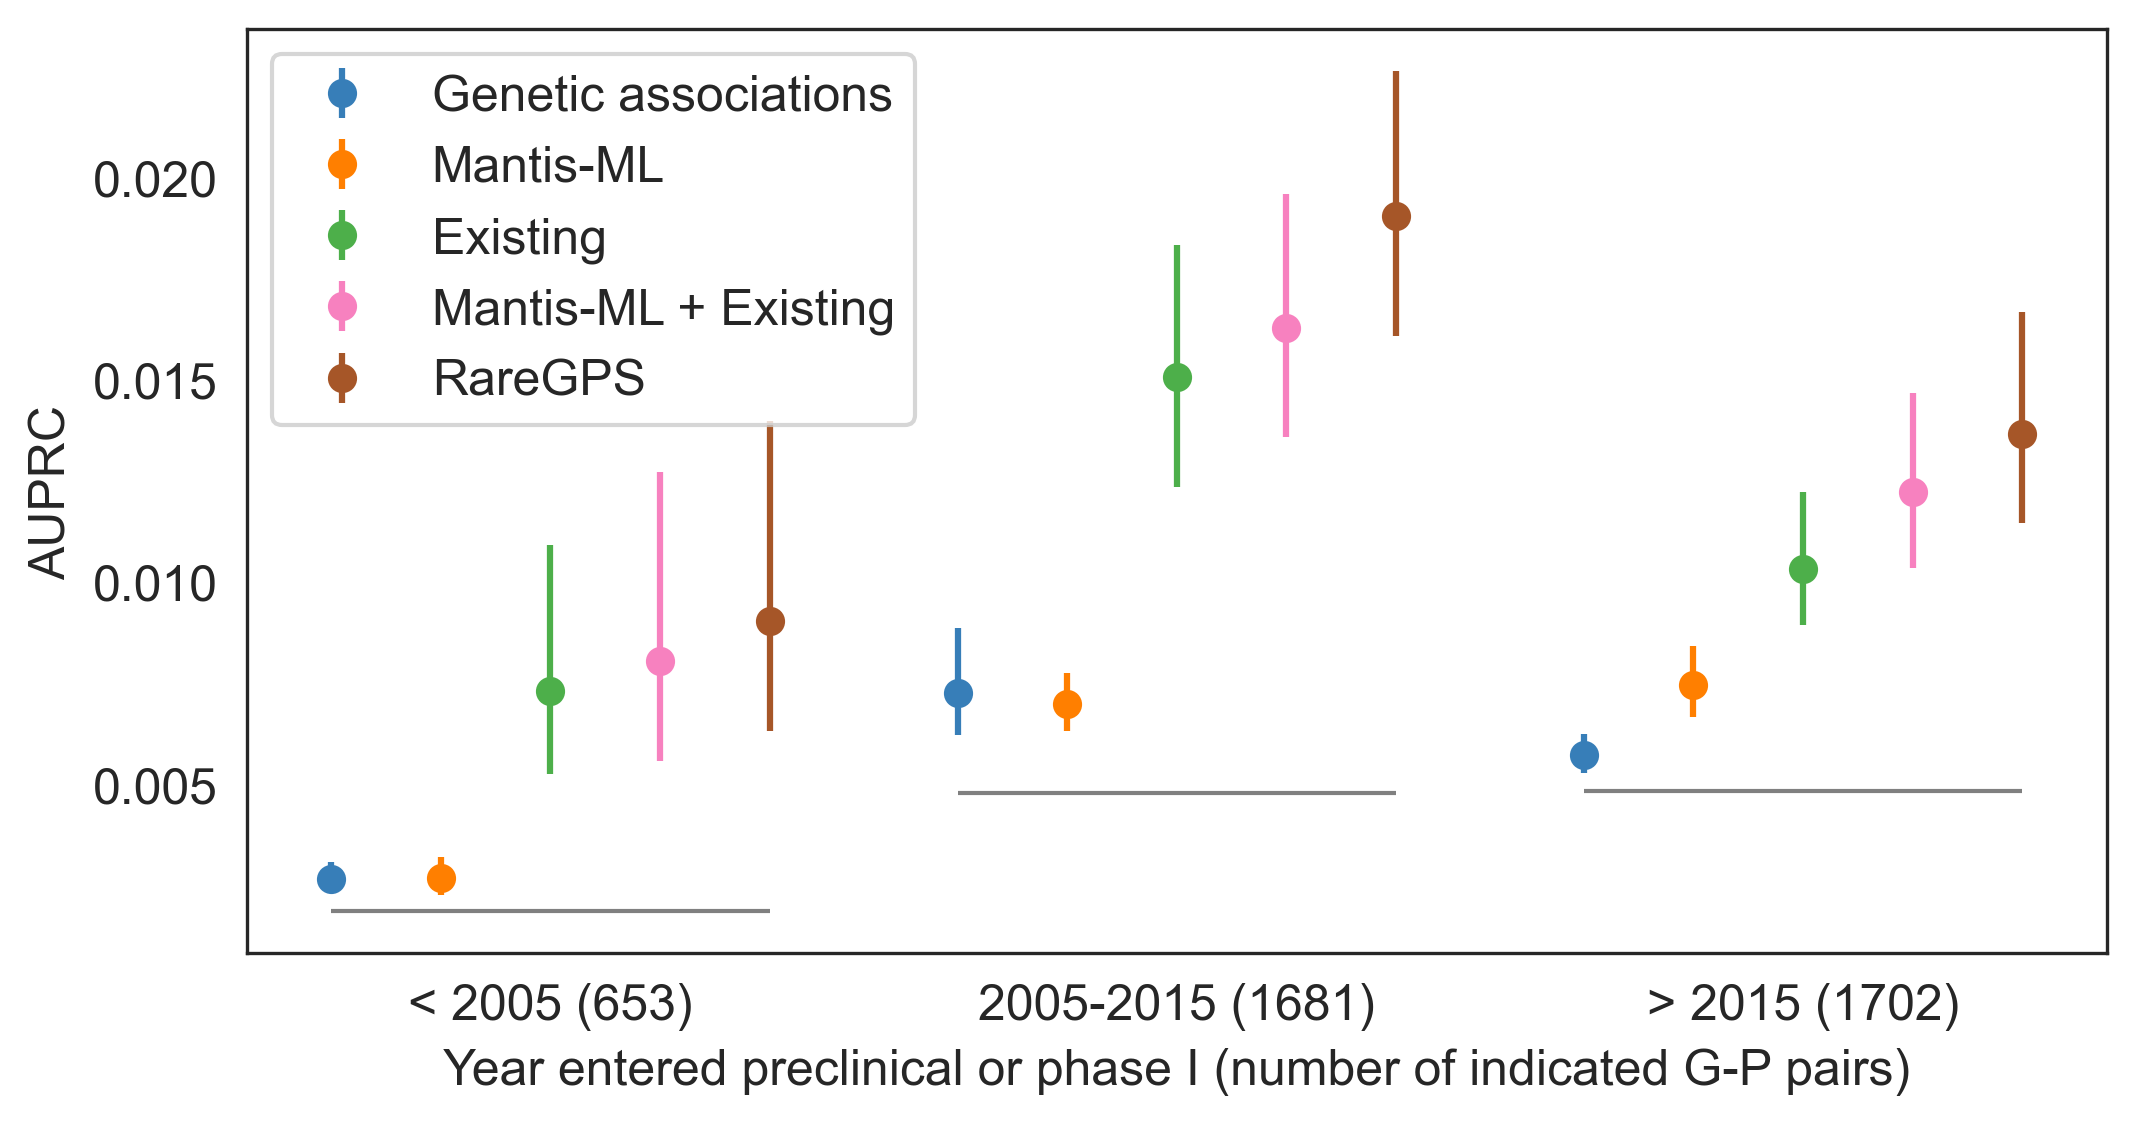

In [22]:
# Calculate error (difference between mean and bounds)
df['error_lower'] = df['AUPRC_mean'] - df['AUPRC_CI_lower']
df['error_upper'] = df['AUPRC_CI_upper'] - df['AUPRC_mean']

# Create the plot
plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

# Define the unique datasets and models
datasets = df['Subset'].unique()
models = df['Model'].unique()

# Generate x positions for each dataset and dodge positions for models
x = np.arange(len(datasets))
width = 0.175  # Width for dodging

# Plot data points with dodging between models
for i, model in enumerate(models):
    model_data = df[df['Model'] == model]
    plt.errorbar(x=x + (i - (len(models) - 1) / 2) * width, 
                 y=model_data['AUPRC_mean'], 
                 yerr=[model_data['error_lower'], model_data['error_upper']], 
                 fmt='o', capsize=0, label=model, color=CB_color_cycle[i])

for i, dataset in enumerate(datasets):
    proportion = df[df['Subset'] == dataset]['Proportion'].iloc[0]
    left = (x[i] - (len(models) - 1) / 2 * width)
    right = (x[i] + (len(models) - 1) / 2 * width)
    plt.hlines(y=proportion, xmin=left, xmax=right, color='gray', linestyle='-', linewidth=1)


# Customize the plot
plt.xticks(ticks=x, labels=datasets)
plt.ylabel('AUPRC')
plt.xlabel('Year entered preclinical or phase I (number of indicated G-P pairs)')
plt.title('')
plt.legend()

plt.show()


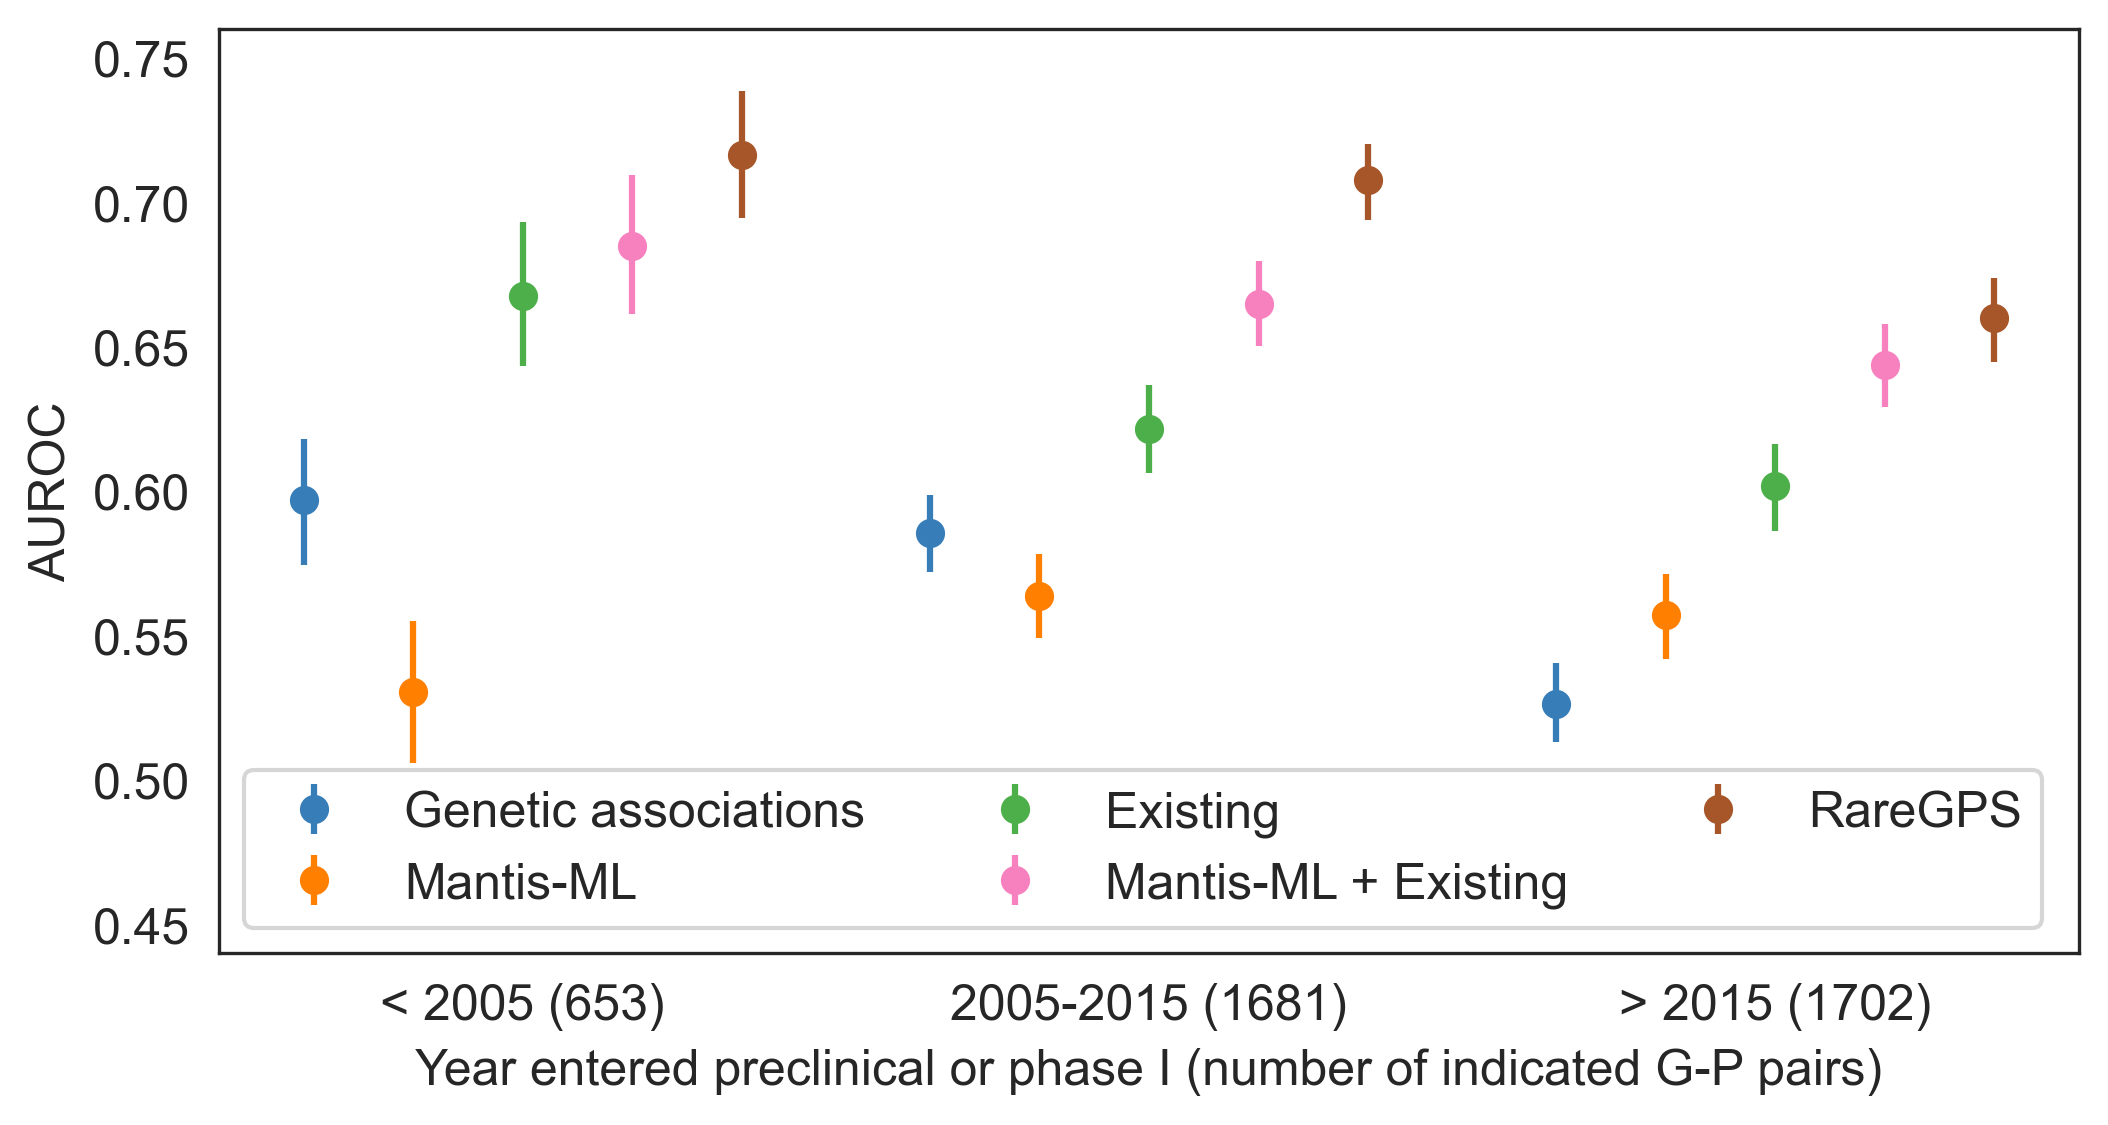

In [27]:
# Calculate error (difference between mean and bounds)
df['error_lower'] = df['AUROC_mean'] - df['AUROC_CI_lower']
df['error_upper'] = df['AUROC_CI_upper'] - df['AUROC_mean']

# Create the plot
plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

# Define the unique datasets and models
datasets = df['Subset'].unique()
models = df['Model'].unique()

# Generate x positions for each dataset and dodge positions for models
x = np.arange(len(datasets))
width = 0.175  # Width for dodging

# Plot data points with dodging between models
for i, model in enumerate(models):
    model_data = df[df['Model'] == model]
    plt.errorbar(x=x + (i - (len(models) - 1) / 2) * width, 
                 y=model_data['AUROC_mean'], 
                 yerr=[model_data['error_lower'], model_data['error_upper']], 
                 fmt='o', capsize=0, label=model, color=CB_color_cycle[i])

# Customize the plot
plt.xticks(ticks=x, labels=datasets)
plt.ylabel('AUROC')
plt.xlabel('Year entered preclinical or phase I (number of indicated G-P pairs)')
plt.title('')
plt.legend(loc='lower left', ncols=3)
plt.ylim([0.44,0.76])

plt.show()


## Phase to phase

In [10]:
cond = 'ot_mantis_cc'

ps = pd.read_pickle('./Resources/phase_success.pkl')    
pdf = pd.read_pickle(f'./GPS/Main/Predictions/holdout_predictions_{cond}.pkl')
pdf = pdf[['id','prediction','indication']].rename({'indication':'0_1'},axis=1)

ps = pdf.merge(ps, on=['id'], how='left')
ps.loc[ps['p_1'] == 0, '0_1'] = 0
ps['0_a'] = ps['1_a'].copy()
ps.loc[ps['max_phase'].isna(), '0_a'] = 0

for col in ['0_1','0_a','1_a']:
    print(len(ps.loc[ps[col].notna()]))
    print(ps[col].sum())
    

356272
5514
354295
406.0
3086
406.0


In [12]:
results = []

conds = ['ot','mantis','cc','ot_mantis','ot_mantis_cc']

for cond in conds:
    
    ps = pd.read_pickle('./Resources/phase_success.pkl')    
    pdf = pd.read_pickle(f'./GPS/Main/Predictions/holdout_predictions_{cond}.pkl')
    pdf = pdf[['id','prediction','indication']].rename({'indication':'0_1'},axis=1)

    ps = pdf.merge(ps, on=['id'], how='left')
    ps.loc[ps['p_1'] == 0, '0_1'] = 0
    ps['0_a'] = ps['1_a'].copy()
    ps.loc[ps['max_phase'].isna(), '0_a'] = 0
    ps = ps.merge(indata['id'])

    for col in ['0_1','0_a','1_2','1_a']:
        print(cond, col)
        try:
            temp = ps.dropna(subset=[col,'prediction']).reset_index(drop=True)
            ci = bootstrap_ci_parallel_joblib(temp[col], temp['prediction'])
            
            results.append({
                'Condition': cond,
                'Phase': col,
                'AUROC': roc_auc_score(temp[col],temp['prediction']),
                'AUROC_CI': ci['auroc'],
                'AUPRC': average_precision_score(temp[col],temp['prediction']),
                'AUPRC_CI': ci['auprc'],
                'Proportion': temp[col].mean()
            })
        except:
            continue

res_df = pd.DataFrame(results)
res_df.to_excel('./Results/bootstrap_metrics_p2p.xlsx', index=False)


ot 0_1
ot 0_a
ot 1_2
ot 1_a
mantis 0_1
mantis 0_a
mantis 1_2
mantis 1_a
cc 0_1
cc 0_a
cc 1_2
cc 1_a
ot_mantis 0_1
ot_mantis 0_a
ot_mantis 1_2
ot_mantis 1_a
ot_mantis_cc 0_1
ot_mantis_cc 0_a
ot_mantis_cc 1_2
ot_mantis_cc 1_a


In [7]:
metrics = pd.read_excel('./Results/bootstrap_metrics_p2p.xlsx').rename({'Condition':'Features'},axis=1)
metrics['Model'] = metrics['Features'].map({'ot':'Existing',
                                             'mantis':'Mantis-ML','cc':'Genetic associations',
                                             'ot_mantis':'Mantis-ML + Existing',
                                             'ot_mantis_cc':'RareGPS'})

df = metrics.copy()
df['Model'] = pd.Categorical(df['Model'], ['Genetic associations','Mantis-ML','Existing',
                                           'Mantis-ML + Existing','RareGPS'])

df = df.loc[df['Phase'] != '1_2']
df['Phase'] = df['Phase'].map({'0_1':'Non-indicated to phase I',
                               '0_a':'Non-indicated to phase IV',
                               '1_a':'Phase I to phase IV'})
df['Phase'] = pd.Categorical(df['Phase'], ['Non-indicated to phase I','Non-indicated to phase IV','Phase I to phase IV'])
df = df.sort_values(['Phase','Model'])

# Separate mean and confidence intervals
df['AUROC_mean'] = df['AUROC_CI'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[1]).astype(float)
df['AUROC_CI_lower'] = df['AUROC_CI'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[0]).astype(float)
df['AUROC_CI_upper'] = df['AUROC_CI'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[2]).astype(float)

df['AUPRC_mean'] = df['AUPRC_CI'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[1]).astype(float)
df['AUPRC_CI_lower'] = df['AUPRC_CI'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[0]).astype(float)
df['AUPRC_CI_upper'] = df['AUPRC_CI'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[2]).astype(float)


Text(0.035, 0.5, 'AUPRC')

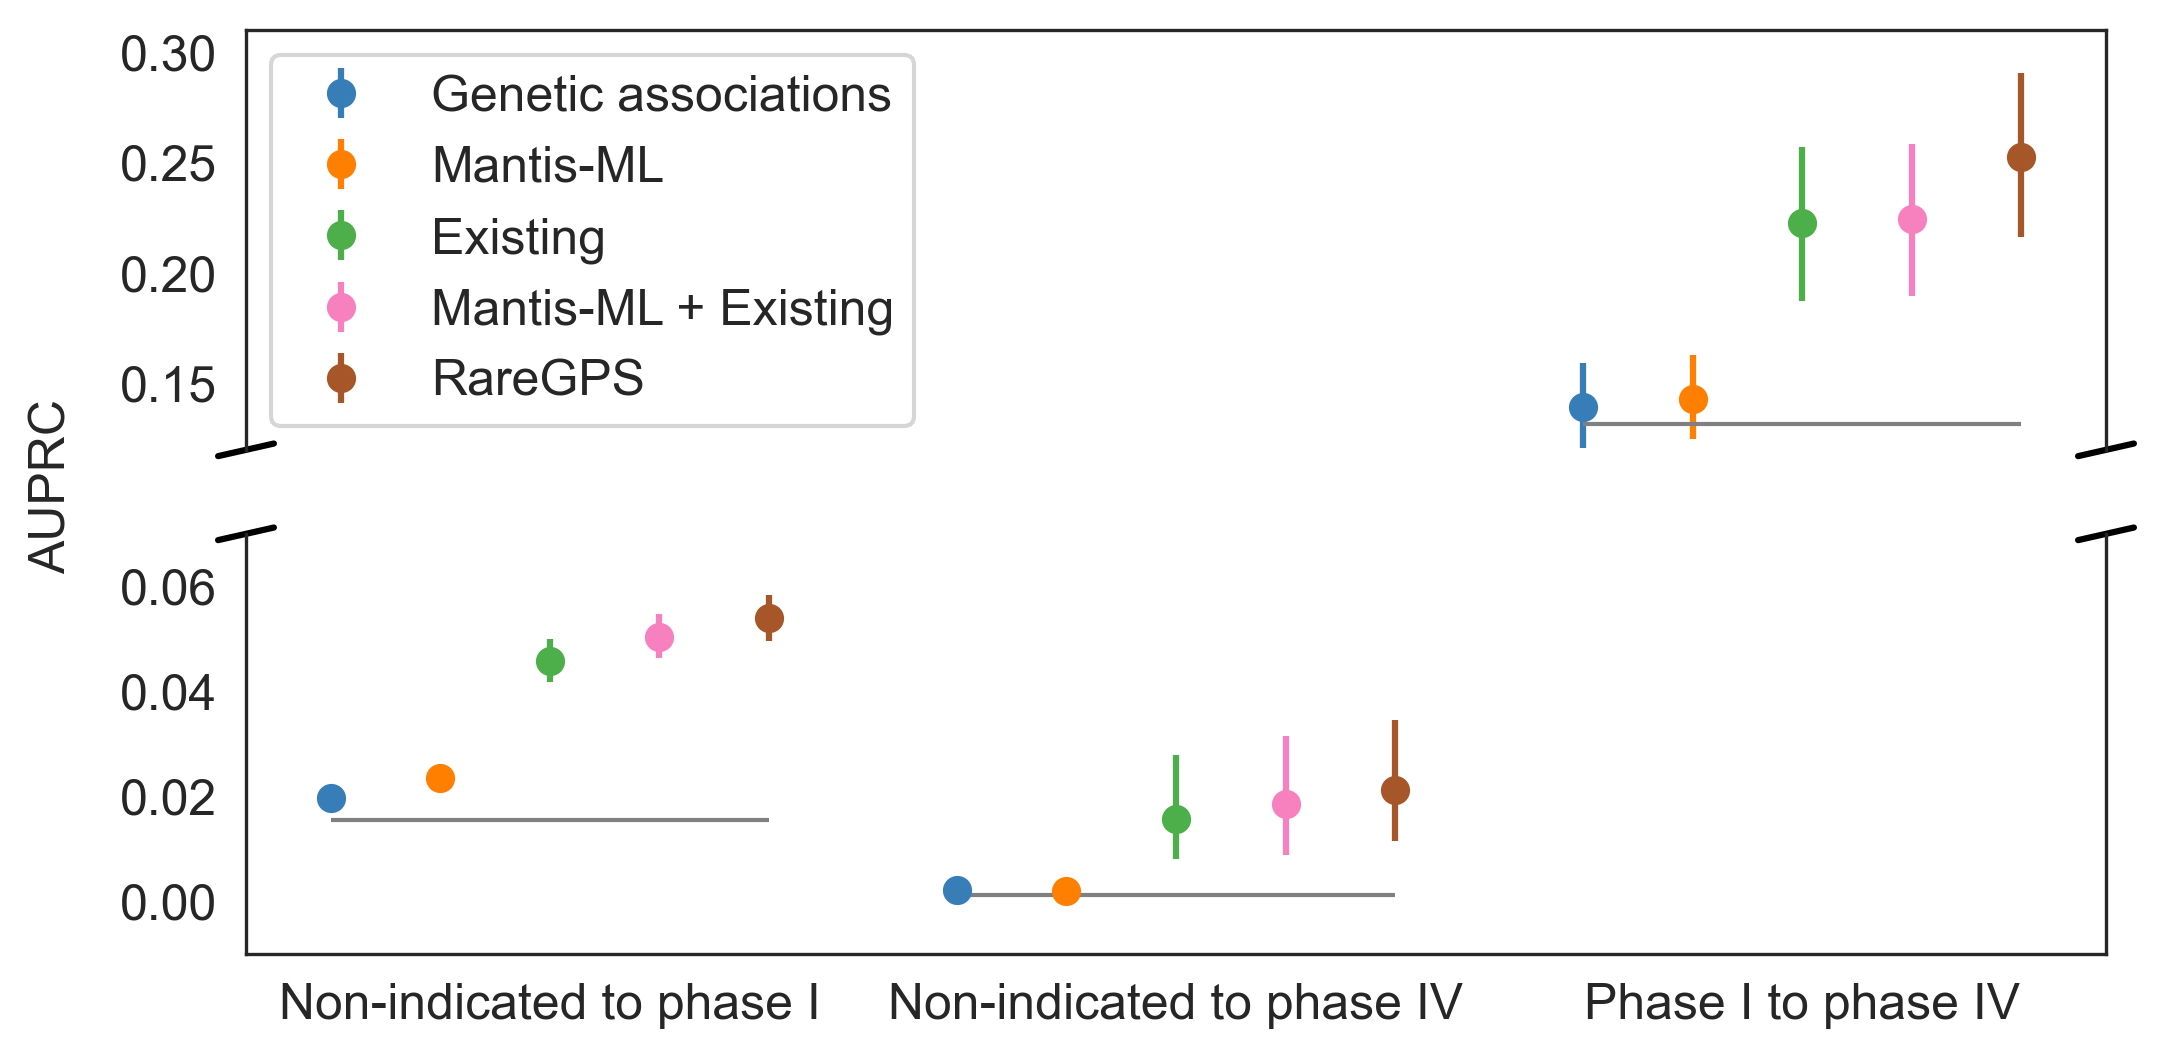

In [8]:
# Calculate error (difference between mean and bounds)
df['error_lower'] = df['AUPRC_mean'] - df['AUPRC_CI_lower']
df['error_upper'] = df['AUPRC_CI_upper'] - df['AUPRC_mean']

# Define the unique datasets and models
datasets = df['Phase'].unique()
models = df['Model'].unique()
x = np.arange(len(datasets))
width = 0.175  # Width for dodging

# Create figure and two subplots for the axis break
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 4), dpi=300, gridspec_kw={'height_ratios': [1, 1]})
sns.set_style('white')

# First subplot for lower range
for i, model in enumerate(models):
    model_data = df[df['Model'] == model]
    ax1.errorbar(x=x + (i - (len(models) - 1) / 2) * width, 
                 y=model_data['AUPRC_mean'], 
                 yerr=[model_data['error_lower'], model_data['error_upper']], 
                 fmt='o', capsize=0, label=model, color=CB_color_cycle[i])

for i, dataset in enumerate(datasets):
    proportion = df[df['Phase'] == dataset]['Proportion'].iloc[0]
    left = (x[i] - (len(models) - 1) / 2 * width)
    right = (x[i] + (len(models) - 1) / 2 * width)
    ax1.hlines(y=proportion, xmin=left, xmax=right, color='gray', linestyle='-', linewidth=1)

# Set y-limits for the lower subplot and remove the top spines
ax1.set_ylim(0.12, 0.31)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(labelbottom=False)

# Second subplot for upper range
for i, model in enumerate(models):
    model_data = df[df['Model'] == model]
    ax2.errorbar(x=x + (i - (len(models) - 1) / 2) * width, 
                 y=model_data['AUPRC_mean'], 
                 yerr=[model_data['error_lower'], model_data['error_upper']], 
                 fmt='o', capsize=0, color=CB_color_cycle[i])

for i, dataset in enumerate(datasets):
    proportion = df[df['Phase'] == dataset]['Proportion'].iloc[0]
    left = (x[i] - (len(models) - 1) / 2 * width)
    right = (x[i] + (len(models) - 1) / 2 * width)
    ax2.hlines(y=proportion, xmin=left, xmax=right, color='gray', linestyle='-', linewidth=1)

# Set y-limits for the upper subplot and remove the bottom spines
ax2.set_ylim(-0.01, 0.07)
ax2.spines['top'].set_visible(False)

# Add diagonal lines to indicate the break
d = 0.015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)

kwargs.update(transform=ax2.transAxes) 
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

# Customize and display
ax2.set_xticks(ticks=x)
ax2.set_xticklabels(datasets)
#ax2.set_ylabel('AUPRC')
ax1.legend(loc='upper left')
ax2.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
fig.text(0.035, 0.5, 'AUPRC', va='center', rotation='vertical')



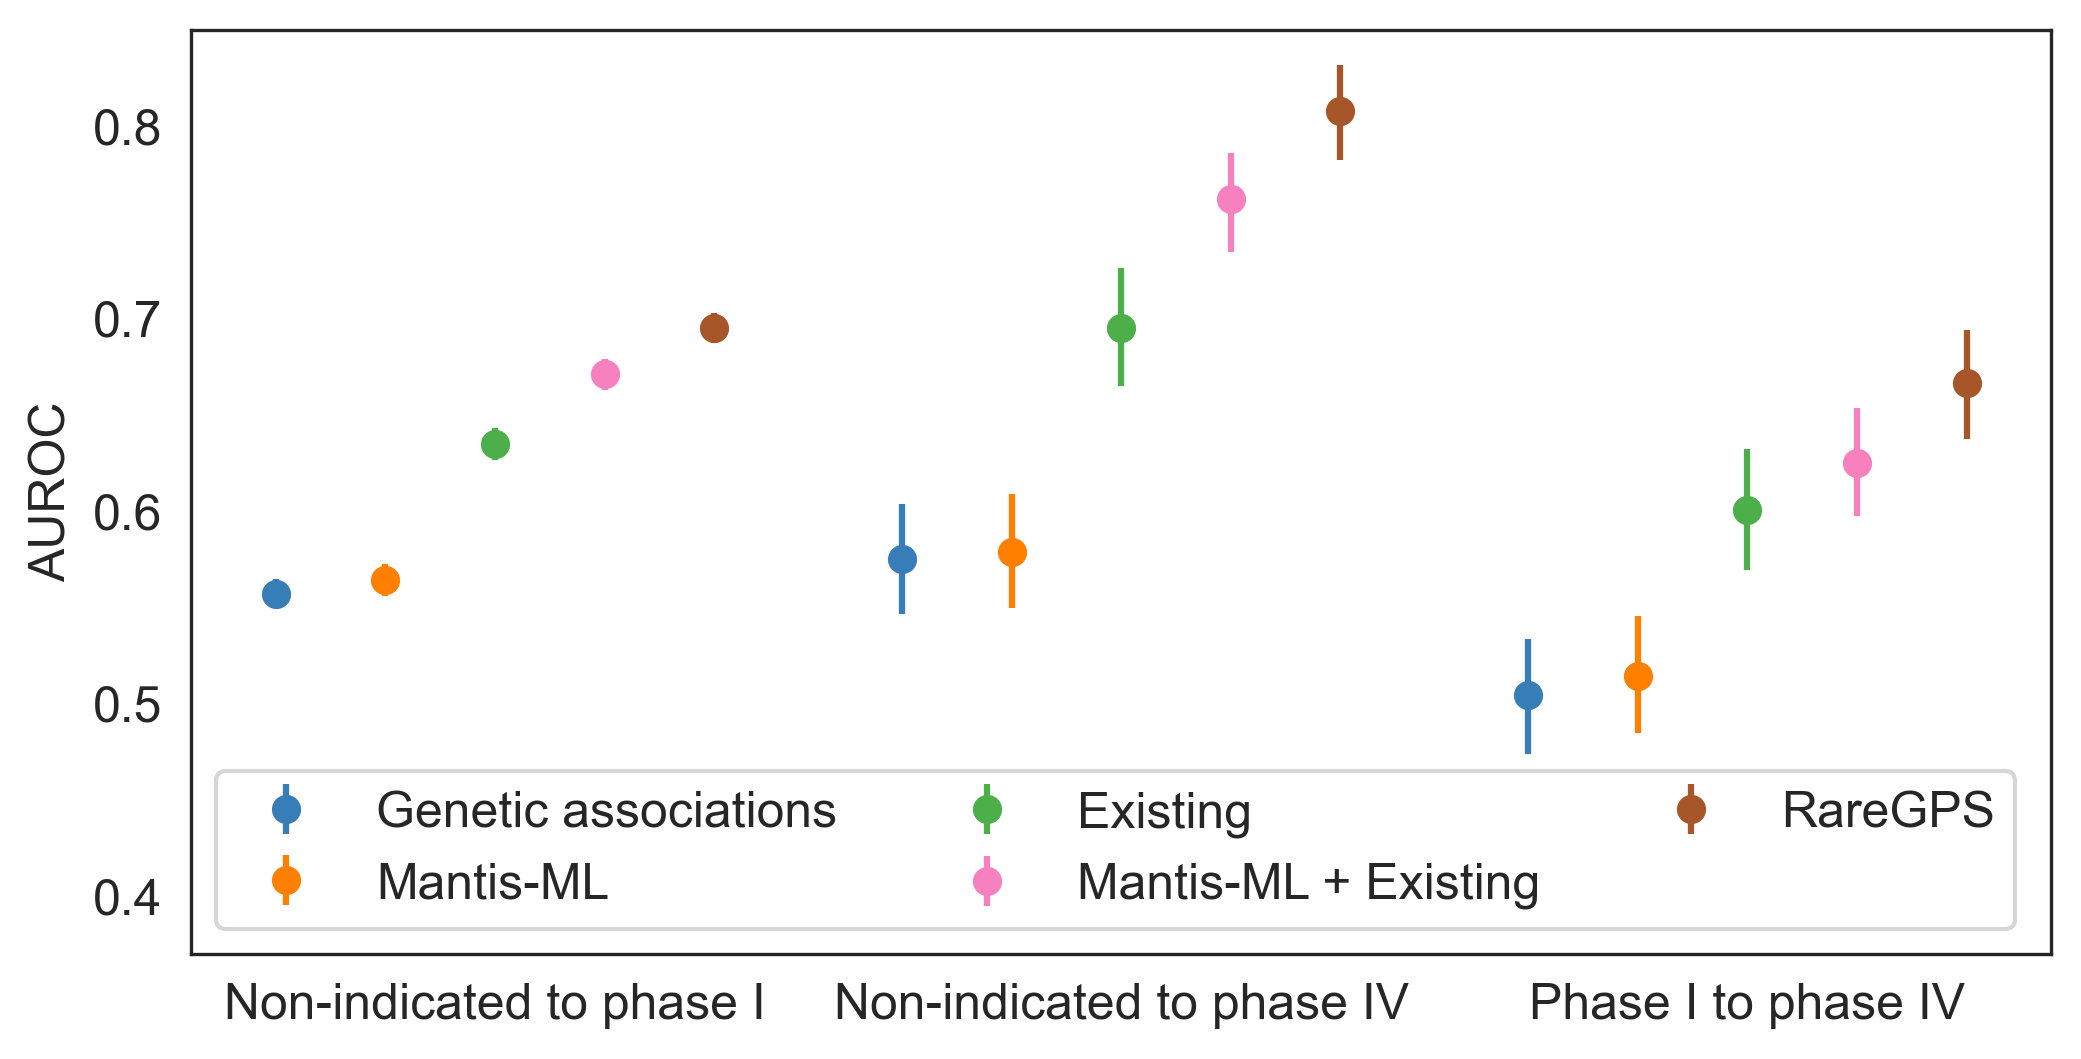

In [17]:
# Calculate error (difference between mean and bounds)
df['error_lower'] = df['AUROC_mean'] - df['AUROC_CI_lower']
df['error_upper'] = df['AUROC_CI_upper'] - df['AUROC_mean']

# Create the plot
plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

# Define the unique datasets and models
datasets = df['Phase'].unique()
models = df['Model'].unique()

# Generate x positions for each dataset and dodge positions for models
x = np.arange(len(datasets))
width = 0.175  # Width for dodging

# Plot data points with dodging between models
for i, model in enumerate(models):
    model_data = df[df['Model'] == model]
    plt.errorbar(x=x + (i - (len(models) - 1) / 2) * width, 
                 y=model_data['AUROC_mean'], 
                 yerr=[model_data['error_lower'], model_data['error_upper']], 
                 fmt='o', capsize=0, label=model, color=CB_color_cycle[i])

# Customize the plot
plt.xticks(ticks=x, labels=datasets)
plt.ylabel('AUROC')
plt.title('')
plt.ylim([0.37,0.85])
plt.legend(loc='lower left', ncols=3)

plt.show()


In [23]:
results = []

conds = ['ot','mantis','cc','ot_mantis','ot_mantis_cc']

for cond in conds:
    ps = pd.read_pickle('./Resources/phase_success.pkl')    
    pdf = pd.read_pickle(f'./GPS/Main/Predictions/holdout_predictions_{cond}.pkl').rename({'indication':'0_1'},axis=1)
    pdf['z_score'] = (pdf['prediction'] - pdf['prediction'].mean())/pdf['prediction'].std()

    pdf['percentile'] = pdf['prediction'].rank(pct=True) * 100
    pdf.loc[(pdf['percentile'] < 75), ['p_90','p_95','p_97','p_99']] = 0
    pdf.loc[(pdf['percentile'] >= 90) & (pdf['percentile'] < 95), 'p_90'] = 1
    pdf.loc[(pdf['percentile'] >= 95) & (pdf['percentile'] < 97), 'p_95'] = 1
    pdf.loc[(pdf['percentile'] >= 97) & (pdf['percentile'] < 99), 'p_97'] = 1
    pdf.loc[pdf['percentile'] >= 99, 'p_99'] = 1
    
    ps = pdf[['id','prediction','z_score','p_95','p_97','p_99','0_1']].merge(ps, on=['id'], how='left')
    ps.loc[ps['p_1'] == 0, '0_1'] = 0
    ps['0_a'] = ps['1_a'].copy()
    ps.loc[ps['max_phase'].isna(), '0_a'] = 0
    ps = ps.merge(indata[['id'] + ['phecode_category']])
    
    for col in ['0_1','0_a','1_a']:
        for metric in ['p_95','p_97','p_99']:
            temp = ps.dropna(subset=[col,metric])
            X = temp[['phecode_category'] + [metric]]
            X = pd.get_dummies(X, columns=['phecode_category'], drop_first=True).astype(float)
            X = X[[metric] + ['phecode_category_GE','phecode_category_MB','phecode_category_NS']] # remove covariates with low counts to avoid singular matrix            
            #X = X.loc[:, (X.sum() > 10) | (X.columns == 'z_score')]
            X = X.fillna(X.median())
            X = sm.add_constant(X)
    
            y = temp[col]
            
            model = sm.Logit(y, X)
            res = model.fit(disp=0, maxiter=1000)
            
            odds_ratio = np.exp(res.params[metric])
            conf = res.conf_int().loc[metric]
            conf_odds_ratio = np.exp(conf) 
            p_value = res.pvalues[metric]
            
            results.append({
                'Metric':metric,
                'Condition': cond,
                'Phase': col,
                'Odds Ratio': odds_ratio,
                '95% Lower': conf_odds_ratio[0],
                '95% Upper': conf_odds_ratio[1],
                'p-value': p_value
            })

res_df = pd.DataFrame(results)
res_df.to_excel('./Results/percentile_p2p.xlsx', index=False)


In [18]:
df = pd.read_excel('./Results/percentile_p2p.xlsx')

df['Model'] = df['Condition'].map({'ot':'Existing',
                                        'mantis':'Mantis-ML','cc':'Genetic associations',
                                        'ot_mantis':'Mantis-ML + Existing',
                                        'ot_mantis_cc':'RareGPS'})
df['Model'] = pd.Categorical(df['Model'], ['Genetic associations','Mantis-ML','Existing',
                                           'Mantis-ML + Existing','RareGPS'])

df['Phase'] = df['Phase'].map({'0_1':'Non-indicated to phase I',
                               '0_a':'Non-indicated to phase IV',
                               '1_a':'Phase I to phase IV'})
df['Phase'] = pd.Categorical(df['Phase'], ['Non-indicated to phase I','Non-indicated to phase IV','Phase I to phase IV'])
df = df.sort_values(['Phase','Model'])
df = df.loc[df['Metric'] == 'p_99']


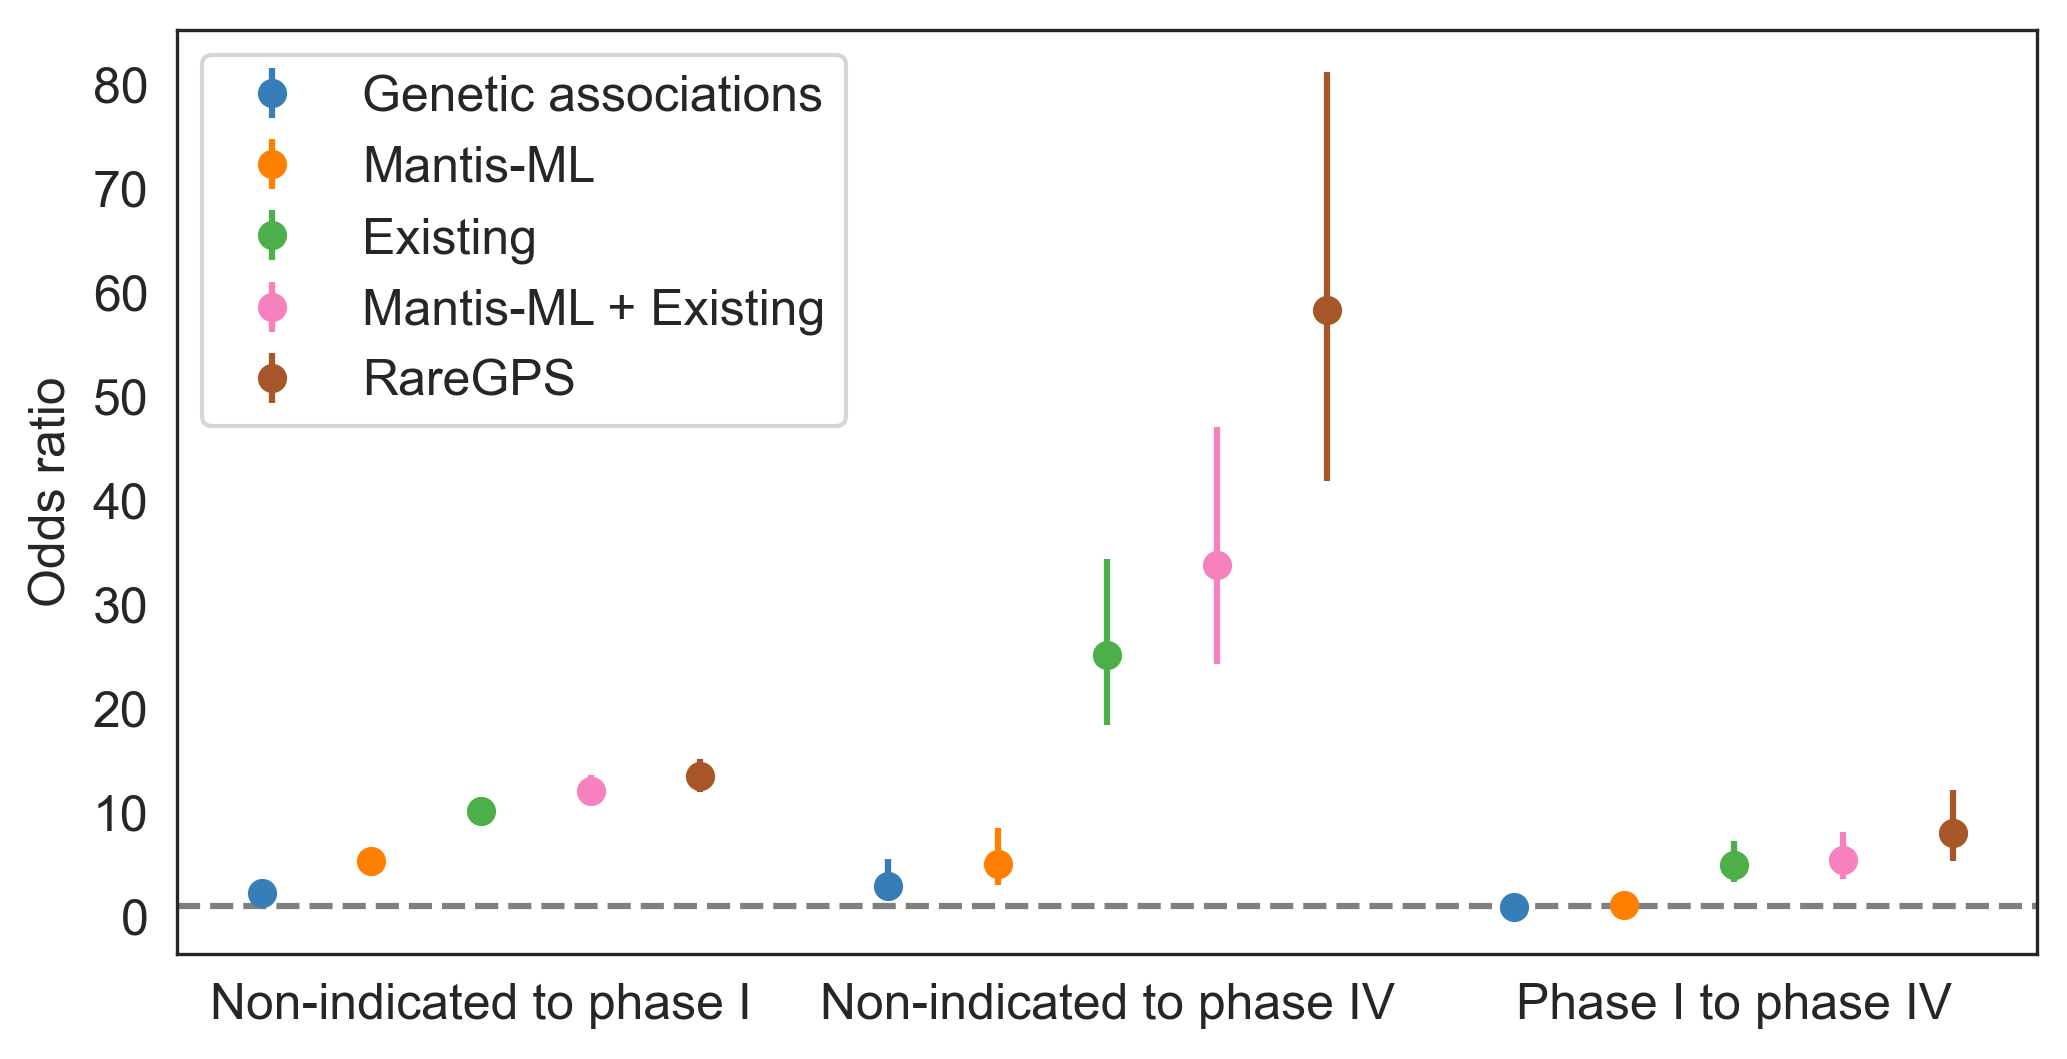

In [19]:
# Calculate error (difference between mean and bounds)
df['error_lower'] = df['Odds Ratio'] - df['95% Lower']
df['error_upper'] = df['95% Upper'] - df['Odds Ratio']

# Create the plot
plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

# Define the unique datasets and models
datasets = df['Phase'].unique()
models = df['Model'].unique()

# Generate x positions for each dataset and dodge positions for models
x = np.arange(len(datasets))
width = 0.175  # Width for dodging

# Plot data points with dodging between models
for i, model in enumerate(models):
    model_data = df[df['Model'] == model]
    plt.errorbar(x=x + (i - (len(models) - 1) / 2) * width, 
                 y=model_data['Odds Ratio'], 
                 yerr=[model_data['error_lower'], model_data['error_upper']], 
                 fmt='o', capsize=0, label=model, color=CB_color_cycle[i])

# Customize the plot
plt.xticks(ticks=x, labels=datasets)
plt.ylabel('Odds ratio')
plt.title('')
plt.legend()
plt.axhline(y=1, color='gray', linestyle='--')

plt.show()


## By case count

In [31]:
results = []

conds = ['ot','mantis','cc','ot_mantis','ot_mantis_cc']

for subset in ['< 0.0005','0.0005-0.001','> 0.001']:
    for cond in conds:
        pdf = pd.read_pickle(f'./GPS/Main/Predictions/holdout_predictions_{cond}.pkl')
        if subset == '< 0.0005':
            pdf = pdf.loc[pdf['phecode'].isin(rd.loc[rd['prop_gp'] < 0.0005]['phecode'])]
        elif subset == '0.0005-0.001':
            pdf = pdf.loc[pdf['phecode'].isin(rd.loc[(rd['prop_gp'] >= 0.0005) & (rd['prop_gp'] < 0.001)]['phecode'])]
        elif subset == '> 0.001':
            pdf = pdf.loc[pdf['phecode'].isin(rd.loc[rd['prop_gp'] >= 0.001]['phecode'])]
        pdf = pdf.reset_index(drop=True)
        auroc = roc_auc_score(pdf['indication'], pdf['prediction'])
        auprc = average_precision_score(pdf['indication'], pdf['prediction'])
        ci = bootstrap_ci_parallel_joblib(pdf['indication'], pdf['prediction'])
        results.append({'Subset':subset,
                        'Phecodes':pdf['phecode'].nunique(),
                        'Indicated G-P':pdf['indication'].sum(),
                        'Features':cond,
                        'AUROC':auroc, 'AUROC_CI': ci['auroc'],
                        'AUPRC':auprc, 'AUPRC_CI': ci['auprc'],
                        'Proportion':pdf['indication'].mean()})

#####

res_df = pd.DataFrame(results)
res_df.to_excel('./Results/bootstrap_metrics_case_count.xlsx', index=False)


In [35]:
metrics = pd.read_excel('./Results/bootstrap_metrics_case_count.xlsx')
metrics['Model'] = metrics['Features'].map({'ot':'Existing',
                                            'mantis':'Mantis-ML','cc':'Genetic associations',
                                            'ot_mantis':'Mantis-ML + Existing',
                                            'ot_mantis_cc':'RareGPS'})

df = metrics.copy()
df['Model'] = pd.Categorical(df['Model'], ['Genetic associations','Mantis-ML','Existing',
                                           'Mantis-ML + Existing','RareGPS'])

df['Subset'] = df['Subset'] + ' (' + df['Indicated G-P'].astype(str) + ')'
subsets_ordered = metrics['Subset'].unique()
subset_counts = metrics.drop_duplicates('Subset').set_index('Subset')['Indicated G-P']
categorical_labels = [f"{subset} ({subset_counts[subset]})" for subset in subsets_ordered]
df['Subset'] = pd.Categorical(df['Subset'], categories=categorical_labels, ordered=True)
df = df.sort_values(['Subset','Model'])

# Separate mean and confidence intervals
df['AUROC_mean'] = df['AUROC_CI'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[1]).astype(float)
df['AUROC_CI_lower'] = df['AUROC_CI'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[0]).astype(float)
df['AUROC_CI_upper'] = df['AUROC_CI'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[2]).astype(float)

df['AUPRC_mean'] = df['AUPRC_CI'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[1]).astype(float)
df['AUPRC_CI_lower'] = df['AUPRC_CI'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[0]).astype(float)
df['AUPRC_CI_upper'] = df['AUPRC_CI'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[2]).astype(float)


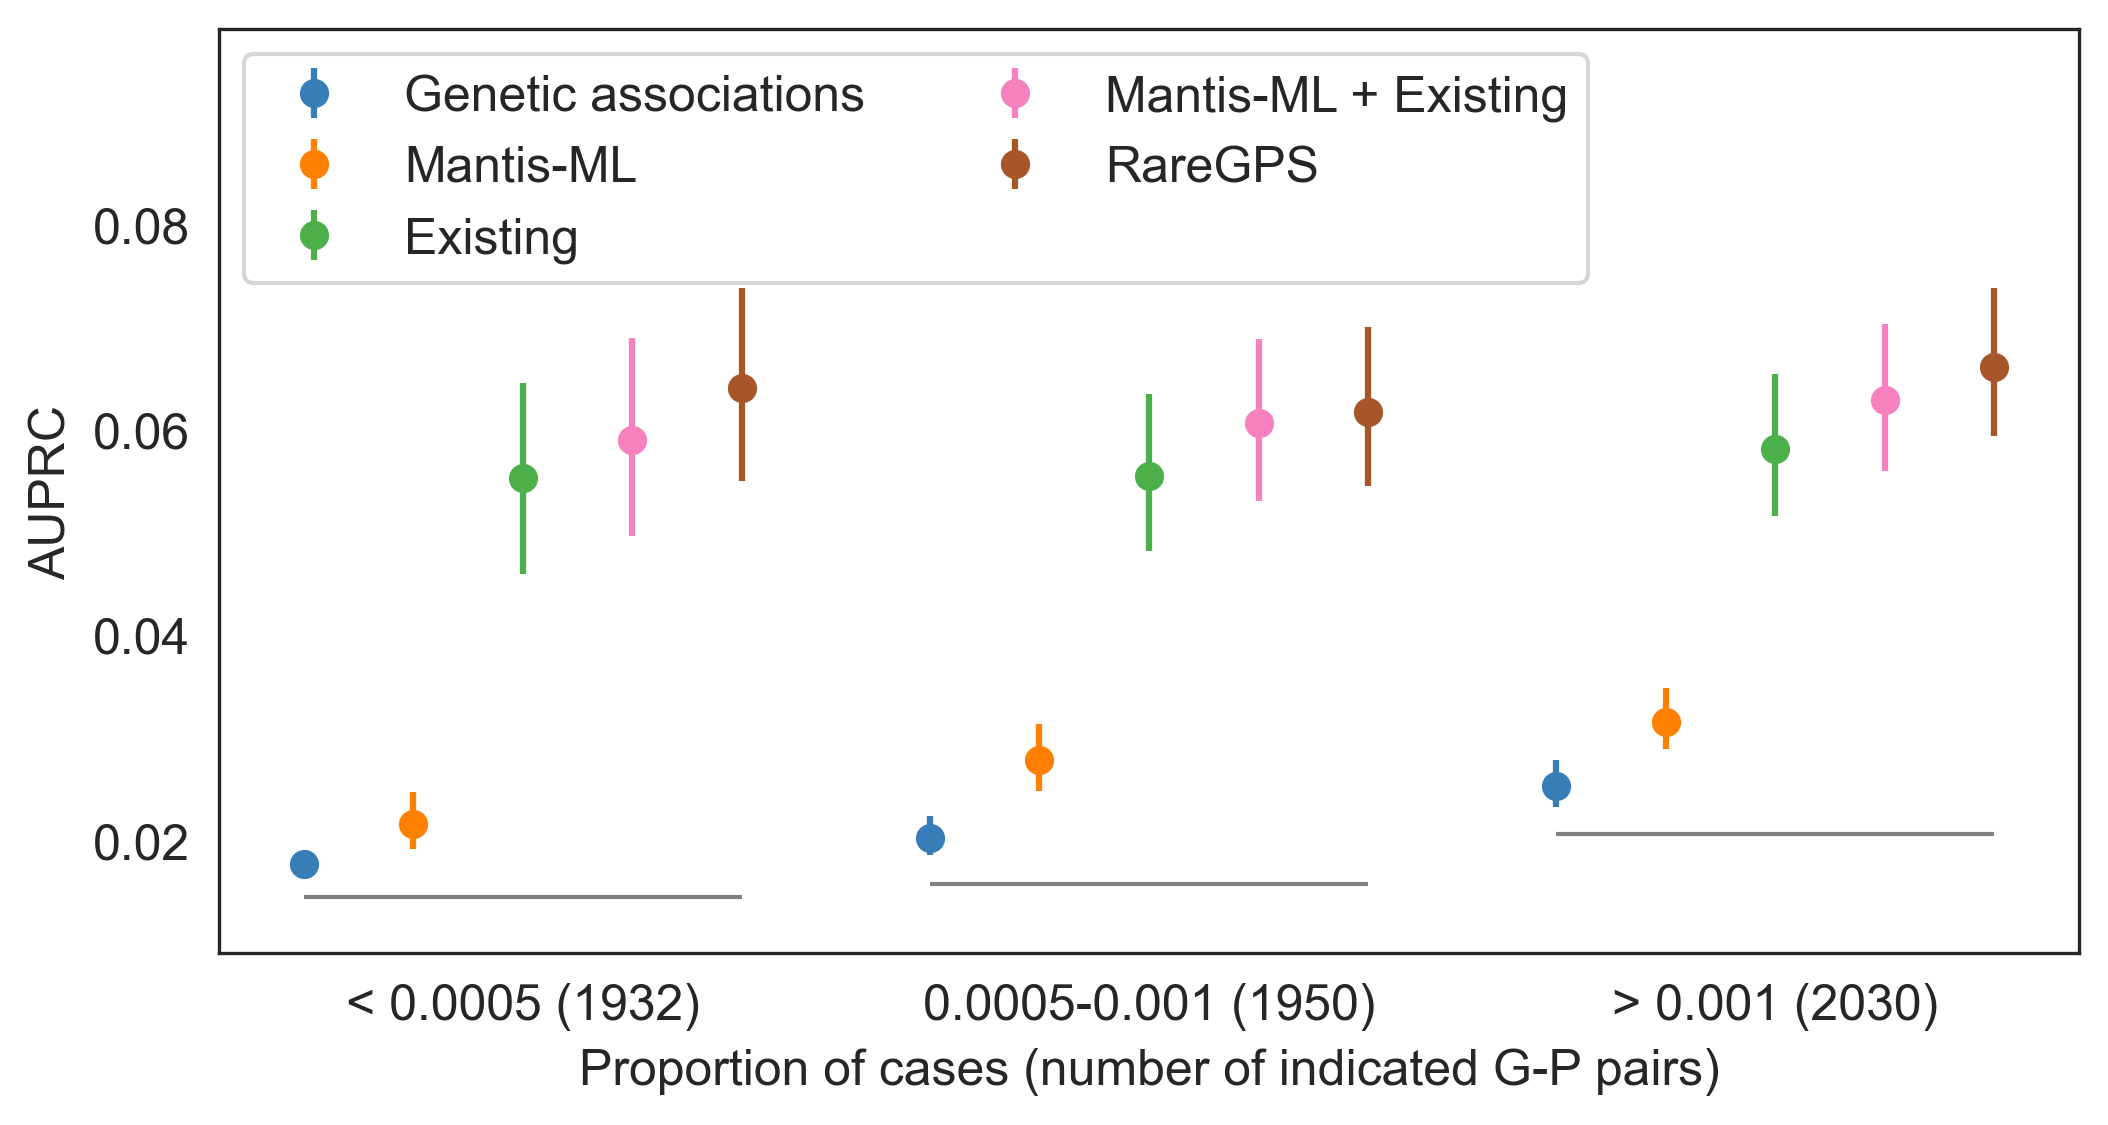

In [39]:
# Calculate error (difference between mean and bounds)
df['error_lower'] = df['AUPRC_mean'] - df['AUPRC_CI_lower']
df['error_upper'] = df['AUPRC_CI_upper'] - df['AUPRC_mean']

# Create the plot
plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

# Define the unique datasets and models
datasets = df['Subset'].unique()
models = df['Model'].unique()

# Generate x positions for each dataset and dodge positions for models
x = np.arange(len(datasets))
width = 0.175  # Width for dodging

# Plot data points with dodging between models
for i, model in enumerate(models):
    model_data = df[df['Model'] == model]
    plt.errorbar(x=x + (i - (len(models) - 1) / 2) * width, 
                 y=model_data['AUPRC_mean'], 
                 yerr=[model_data['error_lower'], model_data['error_upper']], 
                 fmt='o', capsize=0, label=model, color=CB_color_cycle[i])

for i, dataset in enumerate(datasets):
    proportion = df[df['Subset'] == dataset]['Proportion'].iloc[0]
    left = (x[i] - (len(models) - 1) / 2 * width)
    right = (x[i] + (len(models) - 1) / 2 * width)
    plt.hlines(y=proportion, xmin=left, xmax=right, color='gray', linestyle='-', linewidth=1)


# Customize the plot
plt.xticks(ticks=x, labels=datasets)
plt.ylabel('AUPRC')
plt.xlabel('Proportion of cases (number of indicated G-P pairs)')
plt.title('')
plt.legend(loc='upper left', ncols=2)
plt.ylim([0.009,0.099])

plt.show()


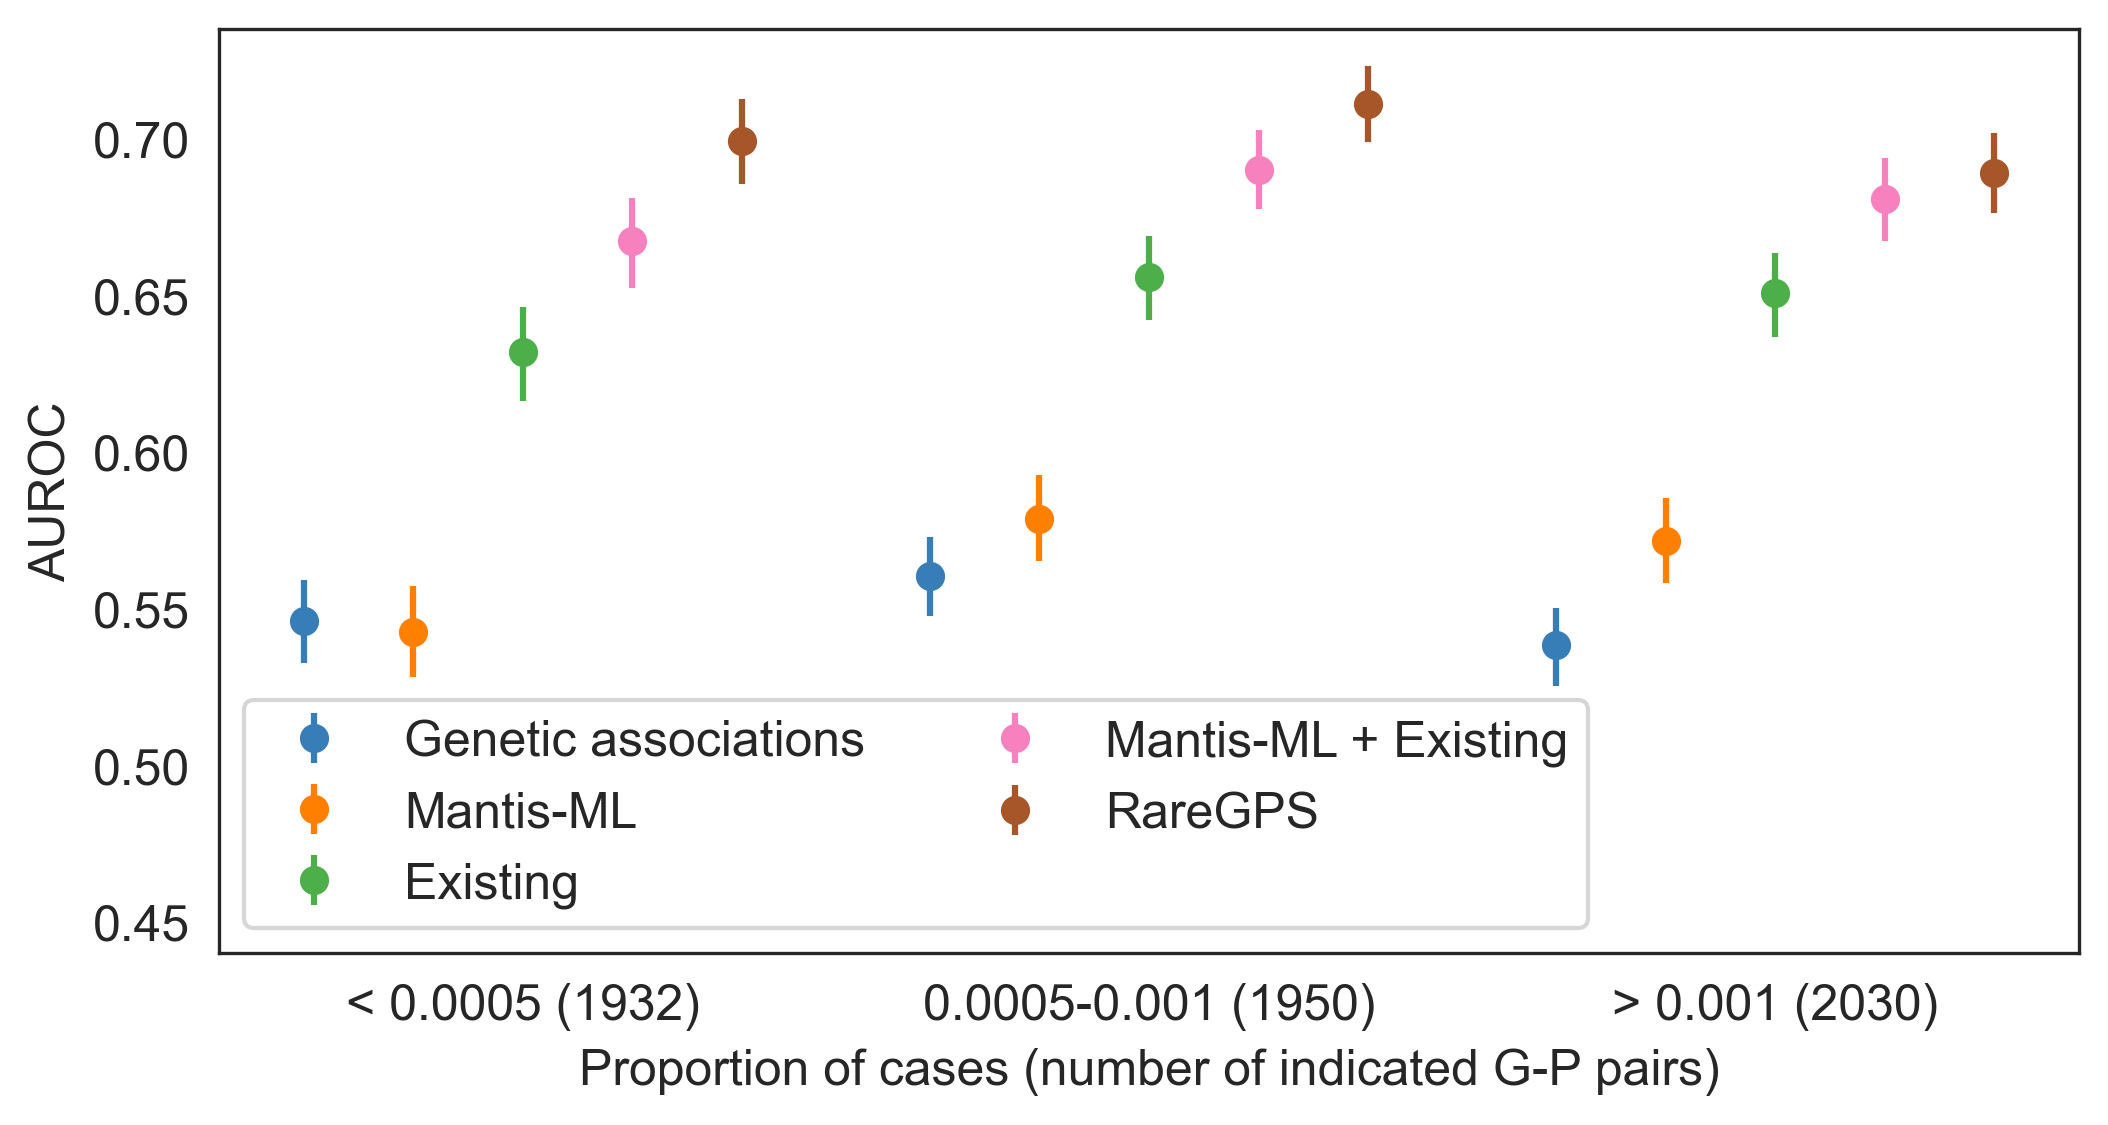

In [40]:
# Calculate error (difference between mean and bounds)
df['error_lower'] = df['AUROC_mean'] - df['AUROC_CI_lower']
df['error_upper'] = df['AUROC_CI_upper'] - df['AUROC_mean']

# Create the plot
plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

# Define the unique datasets and models
datasets = df['Subset'].unique()
models = df['Model'].unique()

# Generate x positions for each dataset and dodge positions for models
x = np.arange(len(datasets))
width = 0.175  # Width for dodging

# Plot data points with dodging between models
for i, model in enumerate(models):
    model_data = df[df['Model'] == model]
    plt.errorbar(x=x + (i - (len(models) - 1) / 2) * width, 
                 y=model_data['AUROC_mean'], 
                 yerr=[model_data['error_lower'], model_data['error_upper']], 
                 fmt='o', capsize=0, label=model, color=CB_color_cycle[i])

# Customize the plot
plt.xticks(ticks=x, labels=datasets)
plt.ylabel('AUROC')
plt.xlabel('Proportion of cases (number of indicated G-P pairs)')
plt.title('')
plt.legend(loc='lower left', ncols=2)
plt.ylim([0.44,0.735])

plt.show()


## By category

In [43]:
results = []

conds = ['ot','mantis','cc','ot_mantis','ot_mantis_cc']

for cond in conds:
    pdf = pd.read_pickle(f'./GPS/Main/Predictions/holdout_predictions_{cond}.pkl')
    pdf['category'] = pdf['phecode'].str.split('_').str[0]
    for pcat in pdf['category'].unique():
        temp = pdf.loc[pdf['category'] == pcat]
        temp = temp.reset_index(drop=True)
        auroc = roc_auc_score(temp['indication'], temp['prediction'])
        auprc = average_precision_score(temp['indication'], temp['prediction'])
        ci = bootstrap_ci_parallel_joblib(temp['indication'], temp['prediction'])
        results.append({'Phecode category':pcat,
                        'Phecodes':temp['phecode'].nunique(),
                        'Indicated G-P':temp['indication'].sum(),
                        'Features':cond,
                        'AUROC':auroc, 'AUROC_CI': ci['auroc'],
                        'AUPRC':auprc, 'AUPRC_CI': ci['auprc'],
                        'Proportion':temp['indication'].mean()})

#####

res_df = pd.DataFrame(results)
res_df.to_excel('./Results/bootstrap_metrics_category.xlsx', index=False)


In [31]:
metrics = pd.read_excel('./Results/bootstrap_metrics_category.xlsx')
metrics['Model'] = metrics['Features'].map({'ot':'Existing',
                                            'mantis':'Mantis-ML','cc':'Genetic associations',
                                            'ot_mantis':'Existing + Mantis-ML',
                                            'ot_mantis_cc':'RareGPS'})

df = metrics.copy()
df['Model'] = pd.Categorical(df['Model'], ['Genetic associations','Mantis-ML','Existing','RareGPS'])
df = df.loc[df['Model'] == 'RareGPS']
df['Phecode category'] = df['Phecode category'].map({'BI':'Blood/Immune','CM':'Congenital','CV':'Cardiovascular','DE':'Dermatological',
                                                     'EM':'Endocrine','GE':'Genetic','GI':'Gastrointestinal',
                                                     'GU':'Genitourinary','MB':'Mental','MS':'Musculoskeletal',
                                                     'NS':'Neurological','RE':'Respiratory','SO':'Sense organs'})
df['Phecode category'] = df['Phecode category'] + ' (' + df['Indicated G-P'].astype(str) + ')'
df = df.sort_values(['Phecode category','Model'])

# Separate mean and confidence intervals
df['AUROC_mean'] = df['AUROC_CI'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[1]).astype(float)
df['AUROC_CI_lower'] = df['AUROC_CI'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[0]).astype(float)
df['AUROC_CI_upper'] = df['AUROC_CI'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[2]).astype(float)

df['AUPRC_mean'] = df['AUPRC_CI'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[1]).astype(float)
df['AUPRC_CI_lower'] = df['AUPRC_CI'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[0]).astype(float)
df['AUPRC_CI_upper'] = df['AUPRC_CI'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[2]).astype(float)


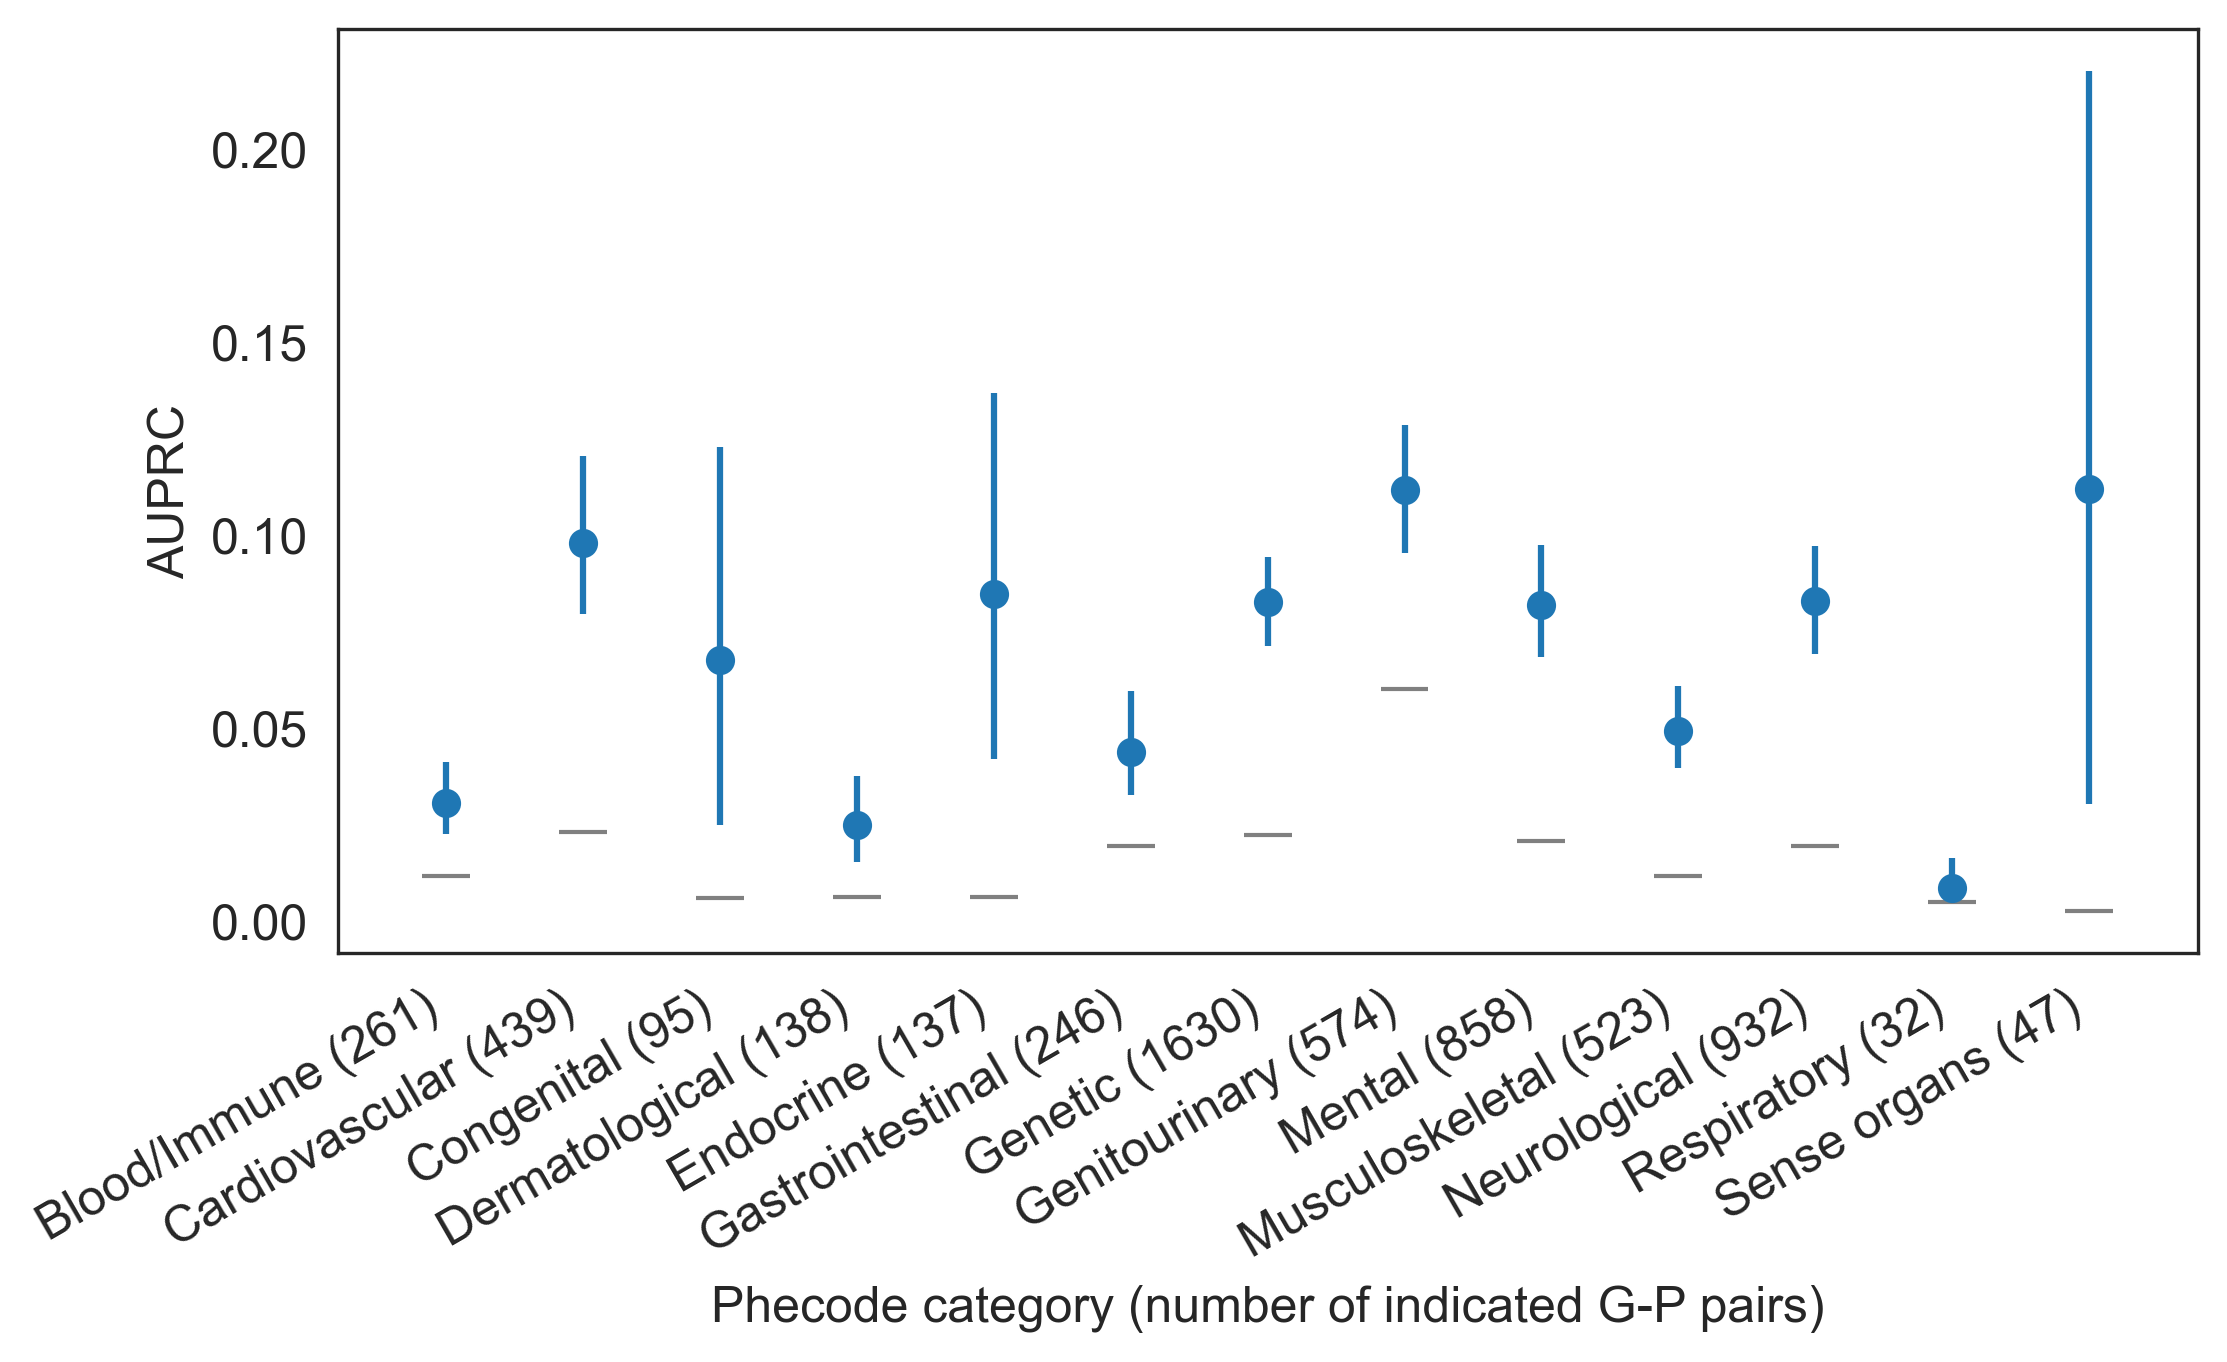

In [32]:
# Calculate error (difference between mean and bounds)
df['error_lower'] = df['AUPRC_mean'] - df['AUPRC_CI_lower']
df['error_upper'] = df['AUPRC_CI_upper'] - df['AUPRC_mean']

# Create the plot
plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

# Define the unique datasets and models
datasets = df['Phecode category'].unique()

# Generate x positions for each dataset and dodge positions for models
x = np.arange(len(datasets))
width = 0.175  # Width for dodging

# Plot data points with dodging between models
plt.errorbar(x=df['Phecode category'], 
             y=df['AUPRC_mean'], 
             yerr=[df['error_lower'], df['error_upper']], 
             fmt='o', capsize=0)

for i, dataset in enumerate(datasets):
    proportion = df[df['Phecode category'] == dataset]['Proportion'].iloc[0]
    left = (x[i] - width)
    right = (x[i] + width)
    plt.hlines(y=proportion, xmin=left, xmax=right, color='gray', linestyle='-', linewidth=1)

# Customize the plot
plt.xticks(ticks=x, labels=datasets, rotation=30, ha='right')
plt.ylabel('AUPRC')
plt.xlabel('Phecode category (number of indicated G-P pairs)')
plt.title('')
#plt.legend()

plt.show()


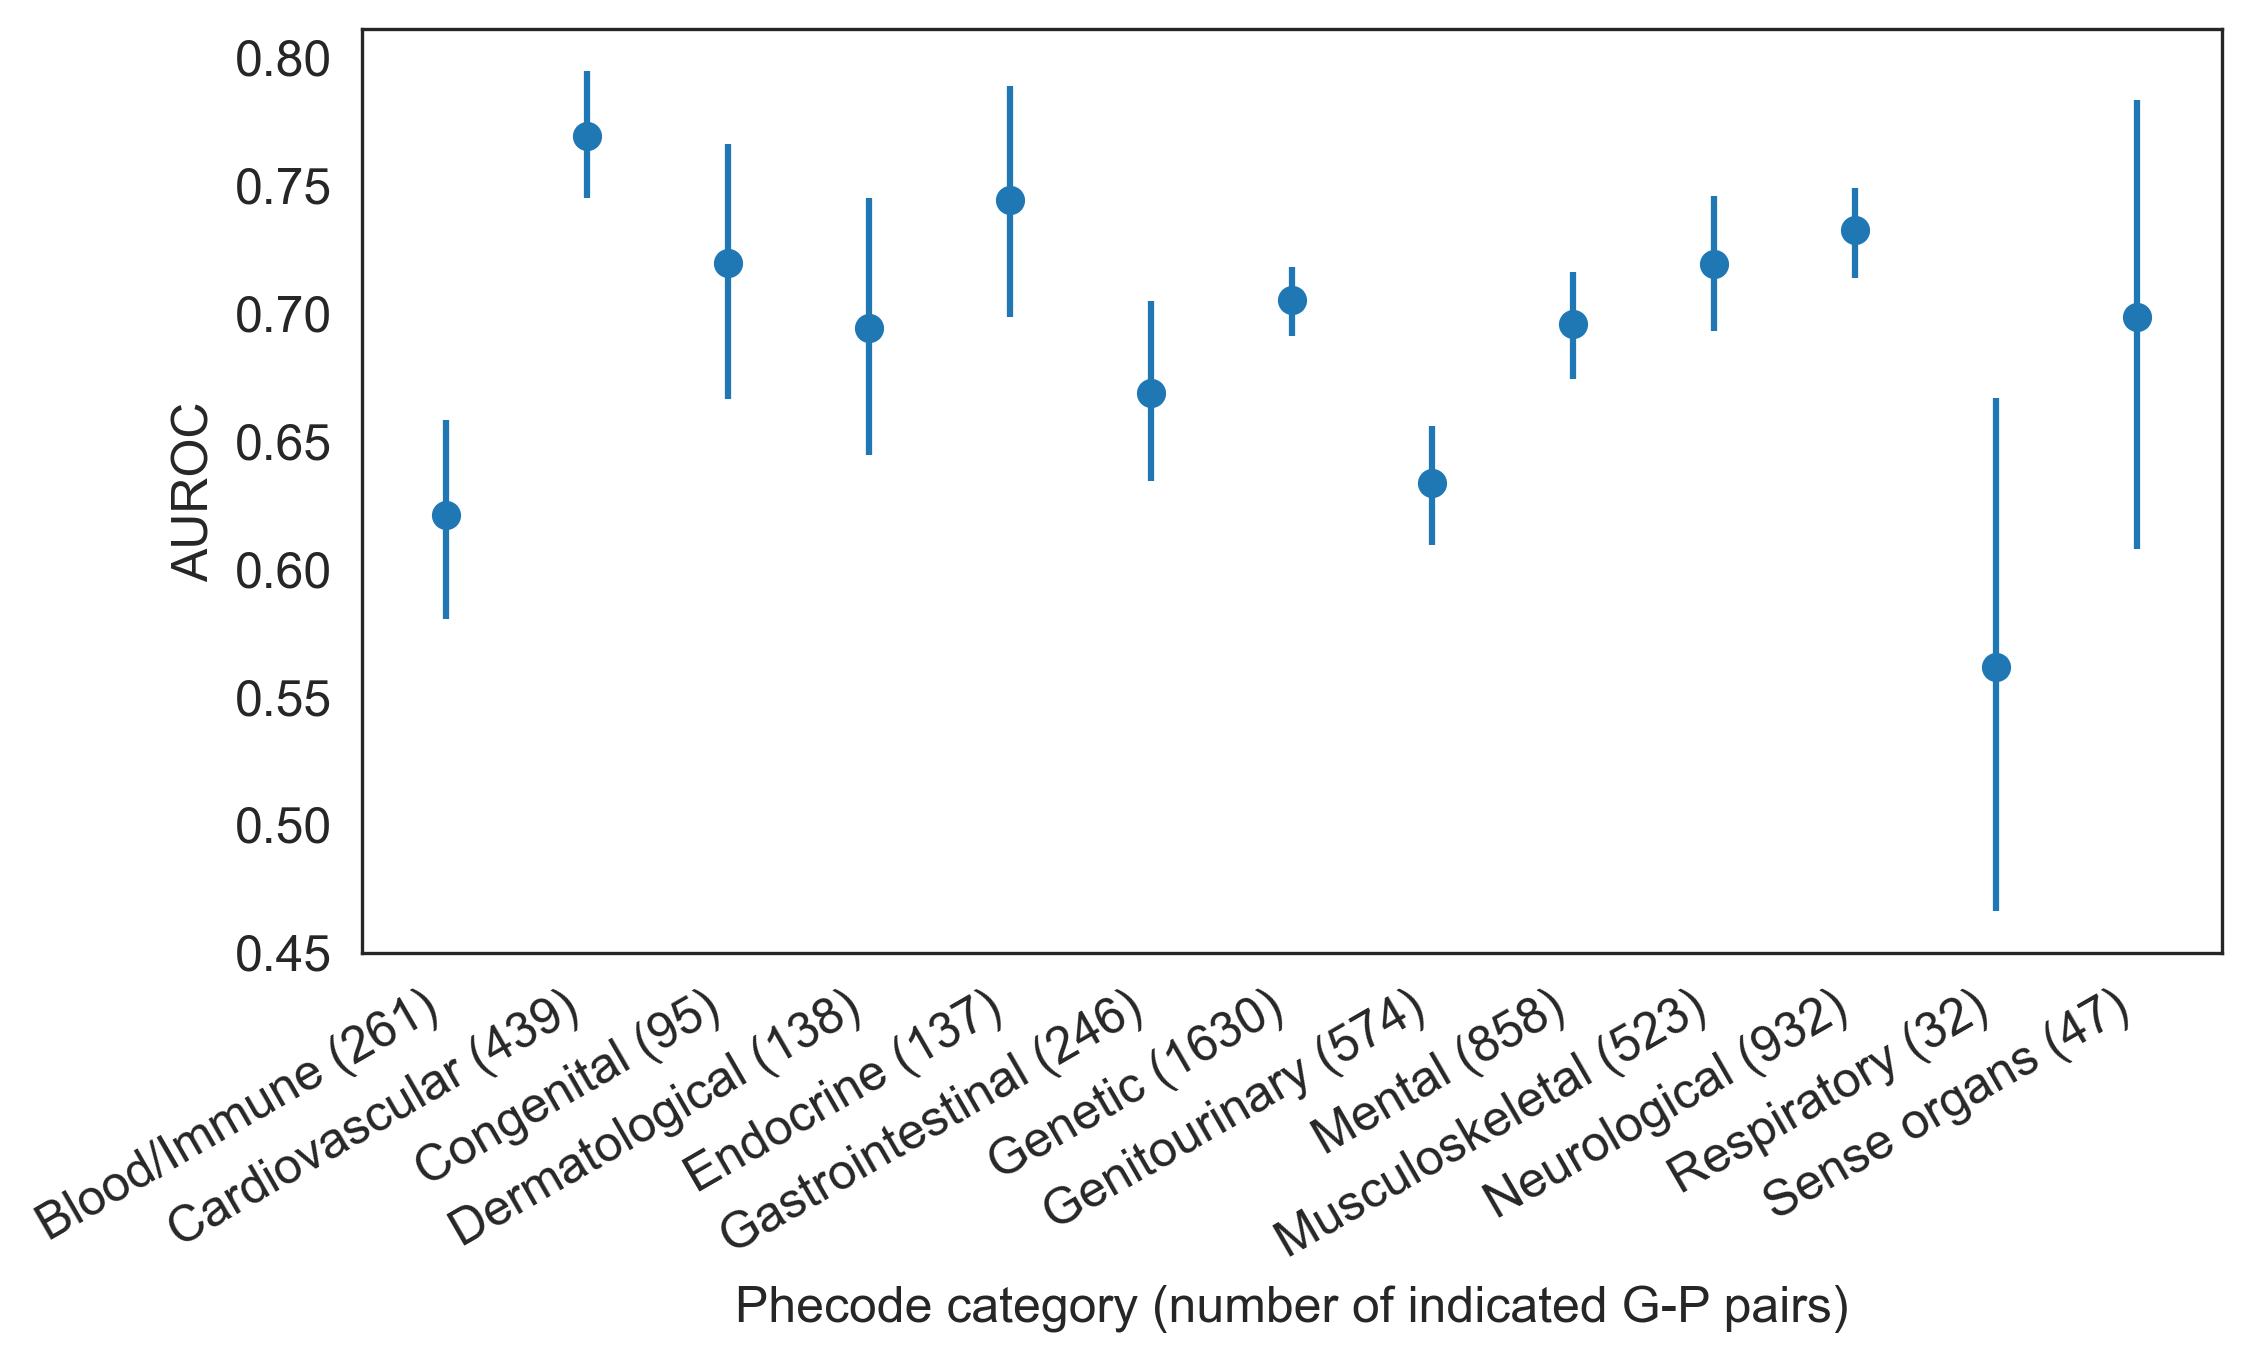

In [33]:
# Calculate error (difference between mean and bounds)
df['error_lower'] = df['AUROC_mean'] - df['AUROC_CI_lower']
df['error_upper'] = df['AUROC_CI_upper'] - df['AUROC_mean']

# Create the plot
plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

# Define the unique datasets and models
datasets = df['Phecode category'].unique()

# Generate x positions for each dataset and dodge positions for models
x = np.arange(len(datasets))
width = 0.175  # Width for dodging

# Plot data points with dodging between models
plt.errorbar(x=df['Phecode category'], 
             y=df['AUROC_mean'], 
             yerr=[df['error_lower'], df['error_upper']], 
             fmt='o', capsize=0)

# Customize the plot
plt.xticks(ticks=x, labels=datasets, rotation=30, ha='right')
plt.ylabel('AUROC')
plt.xlabel('Phecode category (number of indicated G-P pairs)')
plt.title('')
#plt.legend()

plt.show()
